# Auto Regressive (AR) Time-Series Forecasting (sample station: BETN073)

### Plain txt file to dataframe

Background-rural both for Ozone (O3 - Max daily 8-hour mean *max8h* ozone concentrations) is being read from disk as a CSV file (Older database: https://www.eea.europa.eu/data-and-maps/data/airbase-the-european-air-quality-database-7) for the station "BETN073:43N073 - VEZIN" in Belgium.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import timedelta

fname = "AirBase_BE_v7/BETN073/BETN0730000700100dymax.1-1-1990.31-12-2011"

columnNames = ['month']
for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
    columnNames.append(str(i))
    columnNames.append('validity{}'.format(i))

df1 = pd.read_csv(fname, sep='\t', names=columnNames, lineterminator='\n')
df1['month'] = pd.to_datetime(df1['month'])

FileNotFoundError: File b'AirBase_BE_v7/BETN073/BETN0730000700100dymax.1-1-1990.31-12-2011' does not exist

### Weather data (ECMWF)

Selected variables:
- 10 metre U wind component
- 10 metre wind gust since previous post-processing
- 2 metre temperature
- Boundary layer height
- Sunshine duration
- Surface net solar radiation

Reading data for lat: 50.0 lon: 5.0

In [2]:
from numpy import genfromtxt
# weatherData = genfromtxt('ECMWF\BETN073_6vars_19900101To+31days11years.csv', delimiter=',')
weatherData = genfromtxt('ECMWF\BETN073_51vars_19900101To2000101.csv', delimiter=',')

### Daily time-series (from 1-1-1990 to 31-12-2011)
Initialization of an empty multi-variate time-series frame.
*Note:'Var1' is added as a placeholder for future time-series data augmentation (with weather data for a station).*

In [3]:
minDate = min(df1['month'])
maxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st
#columnsLabels = ['O3', '10FG', 'BLH', '10U', '2T', 'SSR', 'SUND', 'O3-1']
columnsLabels = ['O3','PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4','SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH','TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T','RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR','O3-1']
ts = pd.DataFrame(np.nan, index=pd.date_range(start=minDate, end=maxDate, freq='D'), 
                  columns=columnsLabels)
print ("Min date: {}, Max Date: {}".format(minDate, maxDate))

NameError: name 'df1' is not defined

### Filling empty ts with O3 data (Valid readings: {0}, invalid readings {-1, 0} as Nans)
Only valid ozone data is inserted into the time-series.

In [160]:
for row in df1.itertuples(index=True, name='df1'): # Foreach month
    date = row[1]
    for columnIndex in range(1, df1.shape[1]): # Foreach day
        if columnIndex % 2 == 0: # Even column
            if row[columnIndex + 1] == 1: # If sensor reading valid
                currentDate = date + timedelta(days=((columnIndex - 2) / 2)) # Get year-month-day           
                ts.at[currentDate, 'O3'] = row[columnIndex] # Set value to time-series

In [161]:
weatherData[0][0]

446041.3125

Adding weather data into the dataframe:

In [162]:
columns = 51
row = -1
O3lag1 = 0
column = -1
for dataRow in ts.itertuples(index=True, name='Pandas'):    
    date = dataRow[0]
    row += 1       
    if row < weatherData.shape[0] and column < weatherData.shape[1]:
        for column in range(columns):    
            ts.at[date, columnsLabels[column + 1]] = weatherData[row][column] # Set value to time-series        
        if (row > 0):
            ts.at[date, columnsLabels[columns + 1]] = O3lag1 # Set lag value
    O3lag1 = dataRow[1]    

Time-series plot of O3, first 365 days (1990, with missing data):

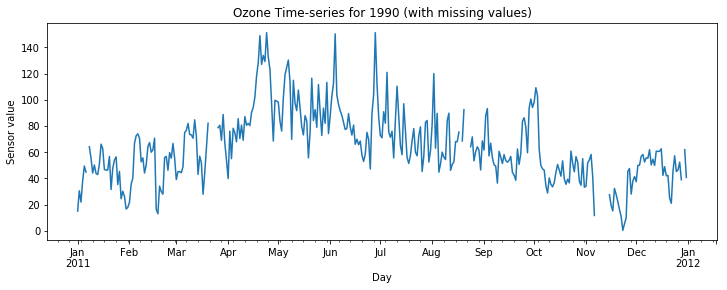

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series for 1990 (with missing values)')
ax.grid(True)
ts.tail(365)['O3'].plot(ax = ax);

Plot other time-series variables (Temperature 2m):

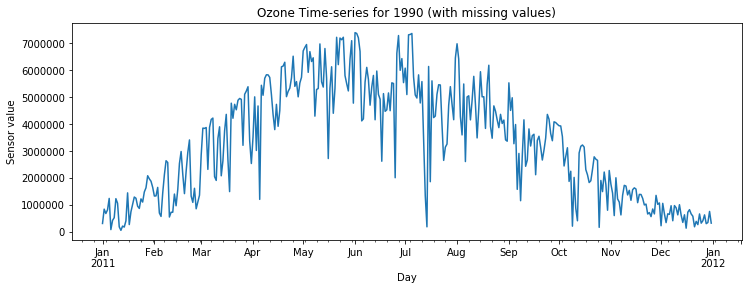

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series for 1990 (with missing values)')
ax.grid(True)
# ts.tail(365)['2T'].plot(ax = ax);
# ['O3', '10FG', 'BLH', '10U', '2T', 'SSR', 'SUND', 'O3-1']
#['O3','PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4','SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH','TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T','RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR','O3-1']
ts.tail(365)['SSR'].plot(ax = ax);

Lag variable (-1 day):

In [165]:
ts.tail(10)['O3']

2011-12-22    21.000
2011-12-23    45.357
2011-12-24    57.286
2011-12-25    45.286
2011-12-26    46.429
2011-12-27    52.375
2011-12-28    39.000
2011-12-29       NaN
2011-12-30    61.938
2011-12-31    40.786
Freq: D, Name: O3, dtype: float64

In [166]:
ts.tail(10)['O3-1']

2011-12-22    24.812
2011-12-23    21.000
2011-12-24    45.357
2011-12-25    57.286
2011-12-26    45.286
2011-12-27    46.429
2011-12-28    52.375
2011-12-29    39.000
2011-12-30       NaN
2011-12-31    61.938
Freq: D, Name: O3-1, dtype: float64

Not useful interpolations: Cubic and Spline (order 2-5+) seem to have very high leverage, skewing the original data:

Useful interpolations: 'from_derivatives' (piecewise polynomial interpolation) and linear. (Probably) the most interesting interpolation: PCHIP 1-d monotonic cubic interpolation (see:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator). Compared to the plain cubic interpolation, doesn't seem to skew the original data points. Pchip looks similar to the linear interpolation, with some extra smoothing.

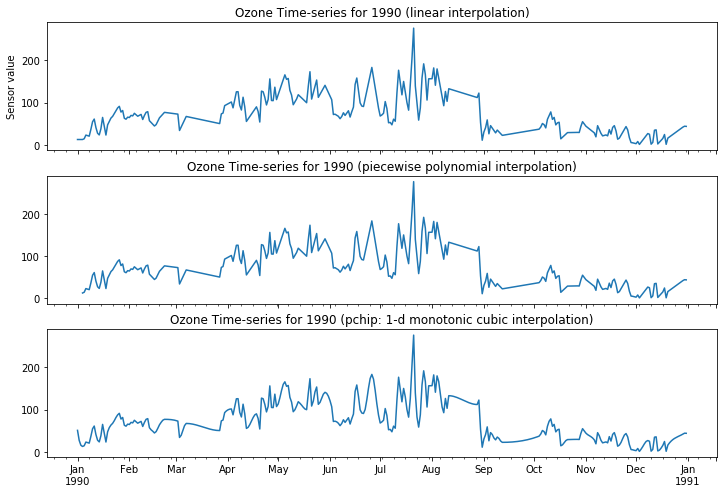

In [167]:
ts2a = ts.interpolate(method='linear',limit=20,limit_direction='both')
ts2b = ts.interpolate(method='from_derivatives',limit=20,limit_direction='both')
ts2c = ts.interpolate(method='pchip',limit=20,limit_direction='both')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True, sharey=True)
ax[0].set_ylabel('Sensor value')
ax[0].set_xlabel('Day')
ax[0].set_title('Ozone Time-series for 1990 (linear interpolation)')
ax[1].set_title('Ozone Time-series for 1990 (piecewise polynomial interpolation)')
ax[2].set_title('Ozone Time-series for 1990 (pchip: 1-d monotonic cubic interpolation)')
ts2a.head(365)['O3'].plot(ax = ax[0]);
ts2b.head(365)['O3'].plot(ax = ax[1]);
ts2c.head(365)['O3'].plot(ax = ax[2]);

In [168]:
ts_interpolated = ts.interpolate(method='linear',limit=80,limit_direction='both')
ts_interpolated.tail(10)['O3']

2011-12-22    21.000
2011-12-23    45.357
2011-12-24    57.286
2011-12-25    45.286
2011-12-26    46.429
2011-12-27    52.375
2011-12-28    39.000
2011-12-29    50.469
2011-12-30    61.938
2011-12-31    40.786
Freq: D, Name: O3, dtype: float64

In [169]:
ts_interpolated.head(30)['O3-1']

1990-01-01    12.714000
1990-01-02    12.714000
1990-01-03    12.714000
1990-01-04    12.714000
1990-01-05    12.714000
1990-01-06    14.500000
1990-01-07    23.143000
1990-01-08    21.884000
1990-01-09    20.625000
1990-01-10    36.750000
1990-01-11    54.571000
1990-01-12    61.000000
1990-01-13    41.000000
1990-01-14    27.500000
1990-01-15    23.500000
1990-01-16    38.250000
1990-01-17    64.875000
1990-01-18    44.062500
1990-01-19    23.250000
1990-01-20    47.333000
1990-01-21    55.333000
1990-01-22    63.333000
1990-01-23    67.375000
1990-01-24    74.041667
1990-01-25    80.708333
1990-01-26    87.375000
1990-01-27    91.125000
1990-01-28    77.500000
1990-01-29    81.286000
1990-01-30    62.875000
Freq: D, Name: O3-1, dtype: float64

In [170]:
ts_interpolated.head(30)['O3']

1990-01-01    12.714000
1990-01-02    12.714000
1990-01-03    12.714000
1990-01-04    12.714000
1990-01-05    14.500000
1990-01-06    23.143000
1990-01-07    21.884000
1990-01-08    20.625000
1990-01-09    36.750000
1990-01-10    54.571000
1990-01-11    61.000000
1990-01-12    41.000000
1990-01-13    27.500000
1990-01-14    23.500000
1990-01-15    38.250000
1990-01-16    64.875000
1990-01-17    44.062500
1990-01-18    23.250000
1990-01-19    47.333000
1990-01-20    55.333000
1990-01-21    63.333000
1990-01-22    67.375000
1990-01-23    74.041667
1990-01-24    80.708333
1990-01-25    87.375000
1990-01-26    91.125000
1990-01-27    77.500000
1990-01-28    81.286000
1990-01-29    62.875000
1990-01-30    60.667000
Freq: D, Name: O3, dtype: float64

In [171]:
# Store to time-series csv
file_name = "BETN073_51vars_O3_O3-1_19900101To2000101.csv"
ts_interpolated.to_csv(file_name, sep=',', encoding='utf-8')

Auto Regressive (AR)

In [1]:
import statsmodels.api as sm
from datetime import datetime

data = ts2c.tail(365)['O3'].values

ModuleNotFoundError: No module named 'patsy'

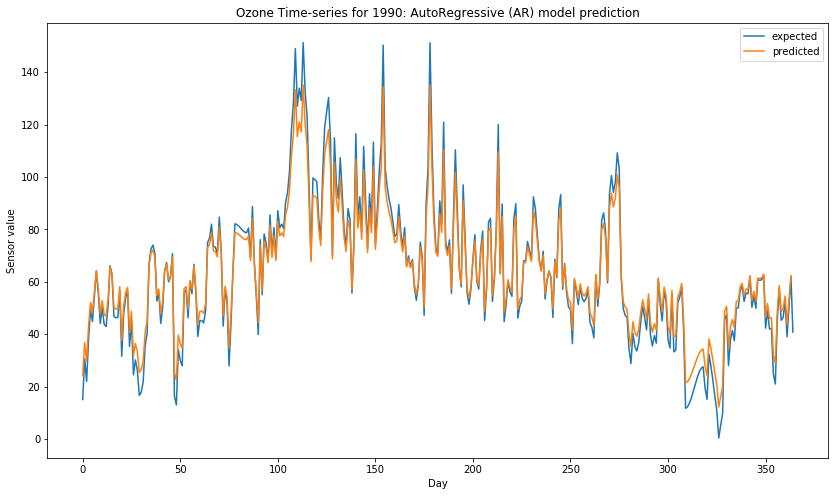

In [17]:
lag = 1
ar_model = sm.tsa.AR(data)
pandas_ar_res = ar_model.fit(maxlag=lag)
pred = pandas_ar_res.predict()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series for 1990: AutoRegressive (AR) model prediction')
plt.plot(data)
plt.plot(pred)
ax.legend(['expected', 'predicted'])

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) # In %
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %
MSE = mean_squared_error(data[:-lag], pred)
MAE = mean_absolute_error(data[:-lag], pred)
MAPE = mean_absolute_percentage_error(data[:-lag], pred)
SMAPE = smape(data[:-lag], pred)
R2_score = r2_score(data[:-lag], pred)

print("MAE: {0:.2f}, MSE: {1:.2f}, \nSMAPE: {2:.2f}%, MAPE: {3:.2f}%, \nR2_score: {4:.2f}"
      .format(MAE, MSE, SMAPE, MAPE, R2_score))

MAE: 3.96, MSE: 25.32, 
SMAPE: 8.74%, MAPE: 18.09%, 
R2_score: 0.97


# TODO: Try detrend + normalize vs standardize

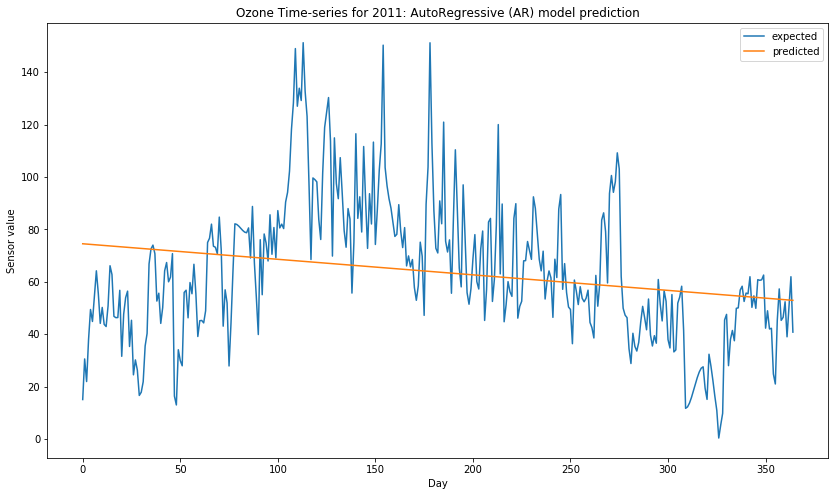

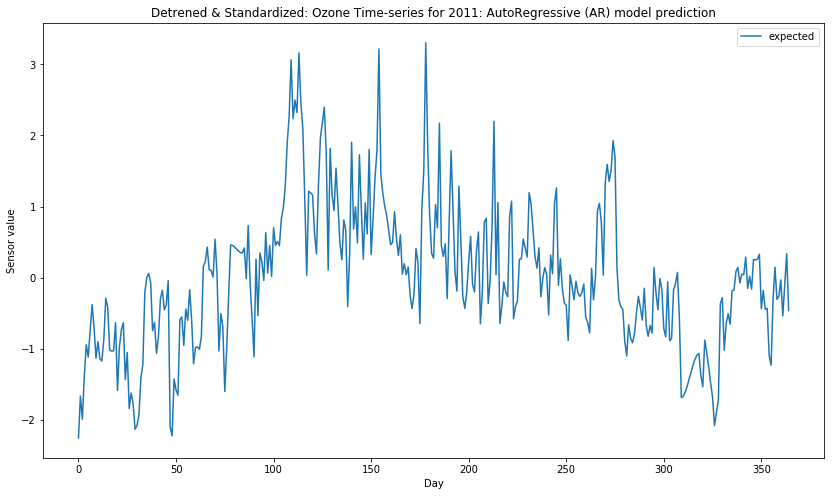

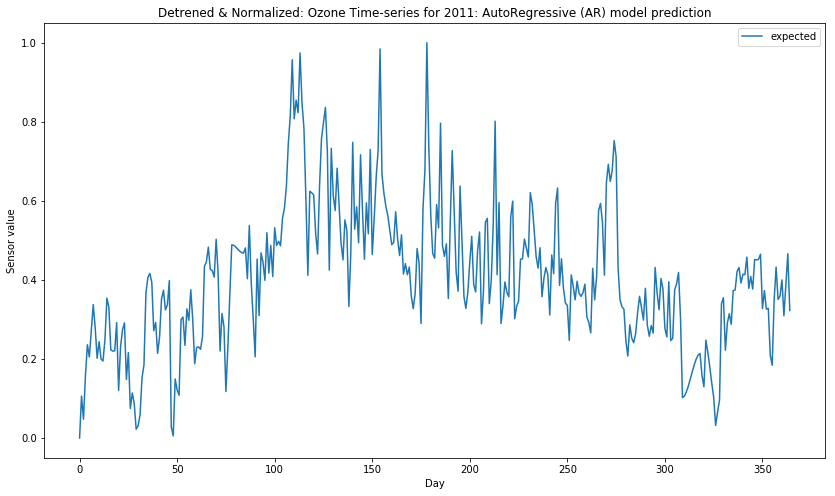

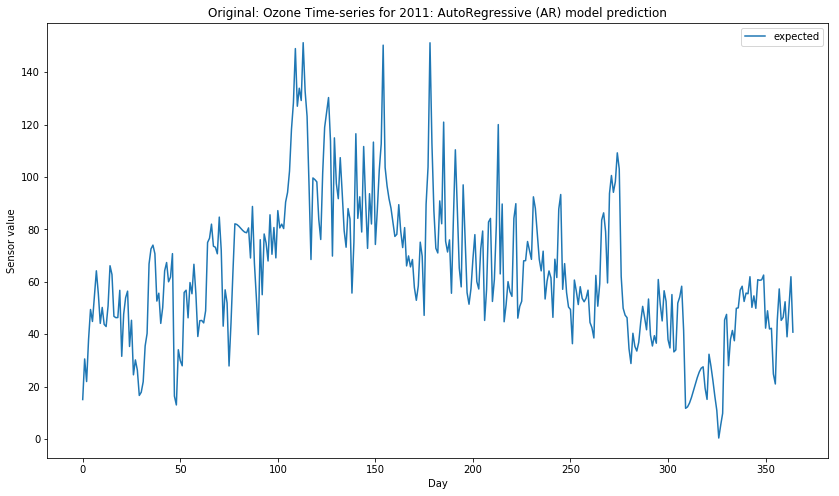

In [25]:
from pandas import read_csv
from pandas import datetime
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy
 
# fit linear model
# data = ts2c.tail(365)['O3'].values
data = ts2c.tail(365 * 1)['O3'].values
series = data
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X) # calculate trend

# plot trend
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(y)
plt.plot(trend)
ax.legend(['expected', 'predicted'])

detrended = [y[i]-trend[i] for i in range(0, len(series))] # detrend
std = np.std(detrended)
mean = np.mean(detrended)
standardized_ts = (detrended-mean)/std # standardize

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Detrened & Standardized: Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(standardized_ts)
ax.legend(['expected', 'predicted'])


normalized_ts = (ts-ts.min())/(ts.max()-ts.min())
min = np.min(detrended)
max = np.max(detrended)
normalized_ts = (detrended-min)/(max-min) # normalize
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Detrened & Normalized: Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(normalized_ts)
ax.legend(['expected', 'predicted'])

# plot original
unstandardized_ts = (standardized_ts * std) + mean
original = [unstandardized_ts[i]+trend[i] for i in range(0, len(series))]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Original: Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(original)
ax.legend(['expected', 'predicted'])


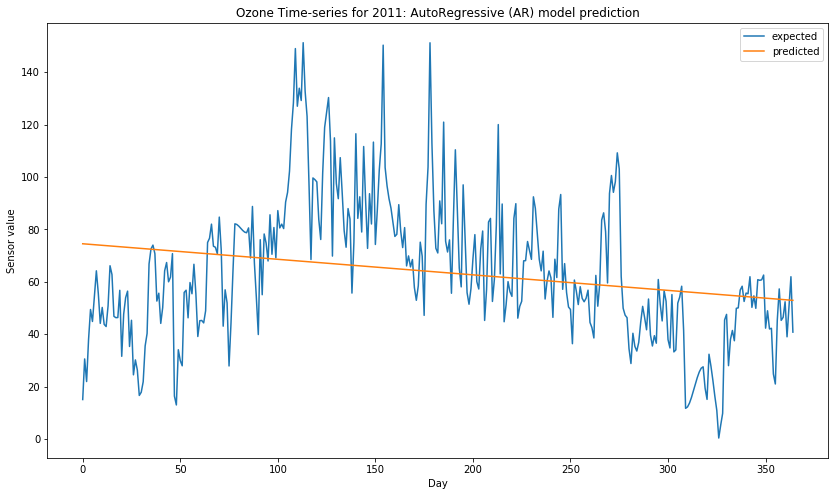

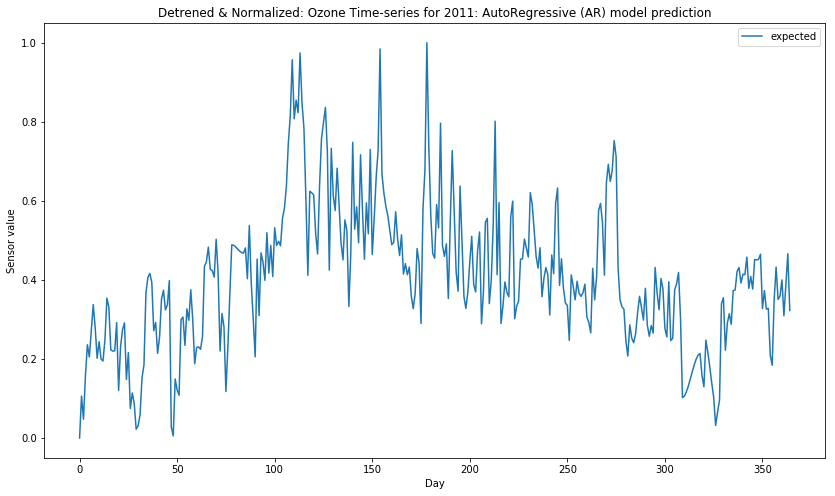

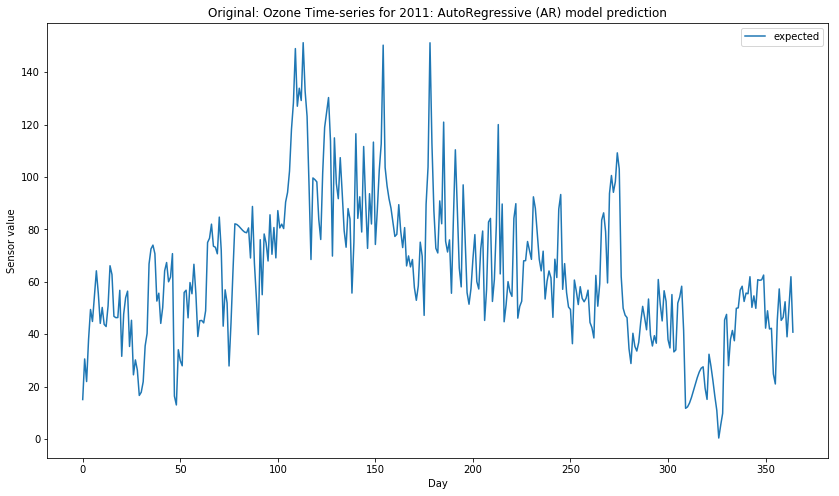

In [24]:
from pandas import read_csv
from pandas import datetime
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy
 
# fit linear model
data = ts2c.tail(365)['O3'].values
# data = ts2c.head(365 * 1)['O3'].values
series = data
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X) # calculate trend

# plot trend
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(y)
plt.plot(trend)
ax.legend(['expected', 'predicted'])

detrended = [y[i]-trend[i] for i in range(0, len(series))] # detrend
std = np.std(detrended)
mean = np.mean(detrended)
standardized_ts = (detrended-mean)/std # standardize


normalized_ts = (ts-ts.min())/(ts.max()-ts.min())
min = np.min(detrended)
max = np.max(detrended)
normalized_ts = (detrended-min)/(max-min) # normalize
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Detrened & Normalized: Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(normalized_ts)
ax.legend(['expected', 'predicted'])

# plot original
unnormalized_ts = normalized_ts * (max - min) + min
original = [unnormalized_ts[i]+trend[i] for i in range(0, len(series))]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Original: Ozone Time-series for 2011: AutoRegressive (AR) model prediction')
plt.plot(original)
ax.legend(['expected', 'predicted'])
